# Example: Run ACS benchmark task

In [1]:
import folktexts
print(f"{folktexts.__version__=}")

folktexts.__version__='0.0.21'


In [2]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd

In [3]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Set important local paths
**NOTE:** Can be ignored if you haven't previously downloaded the model, just use `load_model_tokenizer` with the model's name on Huggingface.

Set your root directory (_**change as appropriate**_):

In [4]:
ROOT_DIR = Path("/fast/groups/sf")
ROOT_DIR

PosixPath('/fast/groups/sf')

Directory where LLMs are saved (_**change as appropriate**_):

In [5]:
MODELS_DIR = ROOT_DIR / "huggingface-models"

Directory where data is saved or will be saved to (_**change as appropriate**_):

In [6]:
DATA_DIR = ROOT_DIR / "data"

Other configs:

In [7]:
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# MODEL_NAME = "google/gemma-2b"    # Smaller model that is faster to run

TASK_NAME = "ACSIncome"

RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results"

In [8]:
from folktexts.llm_utils import load_model_tokenizer, get_model_folder_path
model_folder_path = get_model_folder_path(model_name=MODEL_NAME, root_dir=MODELS_DIR)
model, tokenizer = load_model_tokenizer(model_folder_path)

INFO:root:Loading model '/lustre/fast/fast/groups/sf/huggingface-models/meta-llama--Meta-Llama-3-8B-Instruct'
INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Moving model to device: cuda


In [9]:
results_dir = RESULTS_ROOT_DIR / Path(model_folder_path).name
results_dir.mkdir(exist_ok=True, parents=True)
results_dir

PosixPath('/fast/groups/sf/folktexts-results/meta-llama--Meta-Llama-3-8B-Instruct')

### Construct LLM Classifier

**NOTE:** Also compatible with models hosted through a web API by using the `WebAPILLMClassifier` class instead of `TransformersLLMClassifier`.

Load prediction task (which maps tabular data to text):

In [10]:
from folktexts.acs import ACSTaskMetadata
task = ACSTaskMetadata.get_task(TASK_NAME, use_numeric_qa=True)

INFO:root:Changing Q&A mode for task 'ACSIncome' to numeric.


In [11]:
from folktexts.classifier import TransformersLLMClassifier
llm_clf = TransformersLLMClassifier(
    model=model,
    tokenizer=tokenizer,
    task=task,
    batch_size=32,
    context_size=1000,
)

### Load Dataset

In [12]:
%%time
from folktexts.acs import ACSDataset
dataset = ACSDataset.make_from_task(task=task, cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 56.1 s, sys: 27 s, total: 1min 23s
Wall time: 1min 24s


Optionally, subsample to quickly get approximate results:

In [13]:
dataset.subsample(0.01)
print(f"{dataset.subsampling=}")

INFO:root:Train size: 13316, Test size:  1665, Val size:   1665;


dataset.subsampling=0.01


### Load and run ACS Benchmark

**_Note:_** Helper constructors exist at `Benchmark.make_acs_benchmark` and `Benchmark.make_benchmark` that avoid the above boilerplate code.

In [14]:
from folktexts.benchmark import BenchmarkConfig, Benchmark

bench = Benchmark(llm_clf=llm_clf, dataset=dataset)

INFO:root:
** Benchmark initialization **
Model: meta-llama--Meta-Llama-3-8B-Instruct;
Task: ACSIncome;
Hash: 2930730356;



Here's an example prompt for the current prediction task:

In [15]:
X_sample, _y_sample = dataset.sample_n_train_examples(n=1)
print(llm_clf.encode_row(X_sample.iloc[0], question=llm_clf.task.question))

The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is: 37 years old.
- The class of worker is: Owner of non-incorporated business, professional practice, or farm.
- The highest educational attainment is: Regular high school diploma.
- The marital status is: Married.
- The occupation is: Painters and paperhangers.
- The place of birth is: New Jersey.
- The relationship to the reference person in the survey is: The reference person itself.
- The usual number of hours worked per week is: 40 hours.
- The sex is: Male.
- The race is: White.

Question: What is the probability that this person's estimated yearly income is above $50,000 ?
Answer (between 0 and 1): 0.


Optionally, you can fit the model's threshold on a few data samples.

This is generally quite fast as it is _not fine-tuning_; it only changes one parameter: the `llm_clf.threshold`.

In [16]:
%%time
X_sample, y_sample = dataset.sample_n_train_examples(n=50)
llm_clf.fit(X_sample, y_sample)

INFO:root:No need to correct ordering bias for DirectNumericQA prompting.


Computing risk estimates:   0%|          | 0/2 [00:00<?, ?it/s]

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


CPU times: user 4.86 s, sys: 355 ms, total: 5.21 s
Wall time: 6.75 s


TransformersLLMClassifier(encode_row=functools.partial(<function encode_row_prompt at 0x14d199512d40>, task=ACSTaskMetadata(name='ACSIncome', description="predict whether an individual's income is above $50,000", features=['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P'], target='PINCP', cols_to_text={'AGEP': <folktexts.col_to_text.ColumnToText...
	128253: AddedToken("<|reserved_special_token_248|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128254: AddedToken("<|reserved_special_token_249|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128255: AddedToken("<|reserved_special_token_250|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
})

Run benchmark...

In [17]:
%%time
bench.run(results_root_dir=results_dir)

INFO:root:Test data features shape: (1665, 10)
INFO:root:No need to correct ordering bias for DirectNumericQA prompting.


Computing risk estimates:   0%|          | 0/53 [00:00<?, ?it/s]

INFO:root:
** Test results **
Model: meta-llama--Meta-Llama-3-8B-Instruct;
	 ECE:       22.5%;
	 ROC AUC :  79.9%;
	 Accuracy:  67.5%;
	 Bal. acc.: 72.8%;

INFO:root:Skipping group 'American Indian' as it's too small.
INFO:root:Skipping group 'Alaska Native' as it's too small.
INFO:root:Skipping group 'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races' as it's too small.
INFO:root:Skipping group 'Native Hawaiian and Other Pacific Islander' as it's too small.
INFO:root:Skipping group 'Some other race alone (non-White)' as it's too small.
INFO:root:Skipping group 'Two or more races' as it's too small.
INFO:root:Skipping group American Indian plot as it's too small.
INFO:root:Skipping group Alaska Native plot as it's too small.
INFO:root:Skipping group American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races plot as it's too small.
INFO:root:Skipping gro

CPU times: user 2min 24s, sys: 5.88 s, total: 2min 29s
Wall time: 2min 42s


{'threshold': np.float64(0.65067),
 'n_samples': 1665,
 'n_positives': 605,
 'n_negatives': 1060,
 'model_name': 'meta-llama--Meta-Llama-3-8B-Instruct',
 'accuracy': 0.675075075075075,
 'tpr': 0.9206611570247933,
 'fnr': 0.07933884297520662,
 'fpr': 0.4650943396226415,
 'tnr': 0.5349056603773585,
 'balanced_accuracy': 0.7277834087010759,
 'precision': 0.5304761904761904,
 'ppr': 0.6306306306306306,
 'log_loss': 0.6464883164138935,
 'brier_score_loss': np.float64(0.2292618132401201),
 'fnr_ratio': 0.0,
 'fnr_diff': 1.0,
 'accuracy_ratio': 0.0,
 'accuracy_diff': 1.0,
 'tnr_ratio': 0.0,
 'tnr_diff': 1.0,
 'balanced_accuracy_ratio': 0.0,
 'balanced_accuracy_diff': 1.0,
 'precision_ratio': 0.0,
 'precision_diff': 1.0,
 'ppr_ratio': 0.0,
 'ppr_diff': 0.7019230769230769,
 'fpr_ratio': 0.0,
 'fpr_diff': 1.0,
 'tpr_ratio': 0.0,
 'tpr_diff': 1.0,
 'equalized_odds_ratio': 0.0,
 'equalized_odds_diff': 1.0,
 'roc_auc': np.float64(0.7985560580071729),
 'ece': 0.22473567567567393,
 'ece_quantile': No

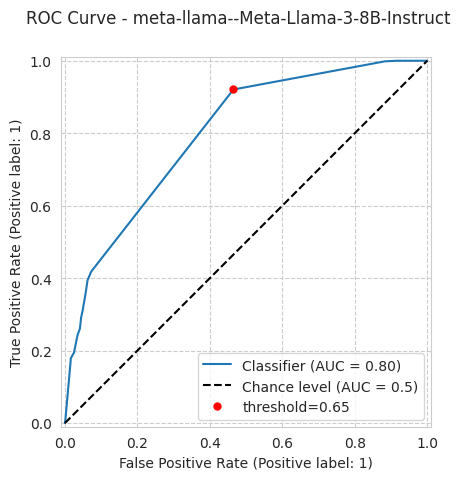

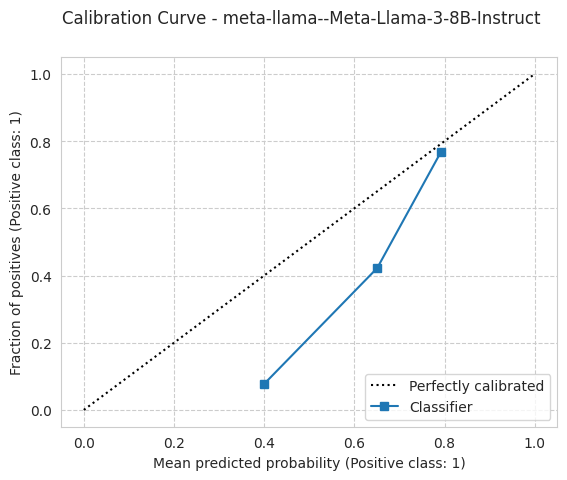

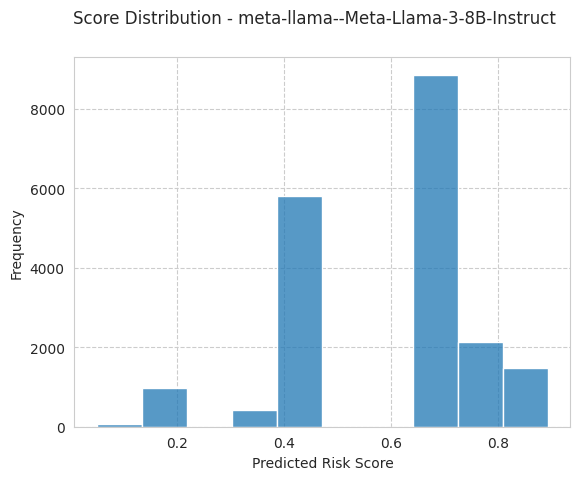

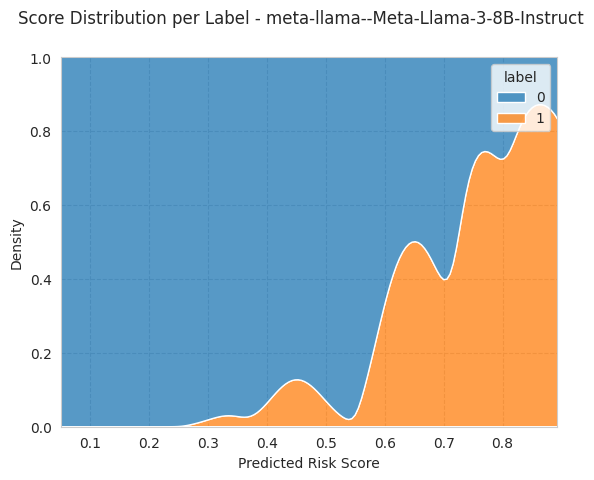

INFO:root:Skipping group 'American Indian' as it's too small.
INFO:root:Skipping group 'Alaska Native' as it's too small.
INFO:root:Skipping group 'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races' as it's too small.
INFO:root:Skipping group 'Native Hawaiian and Other Pacific Islander' as it's too small.
INFO:root:Skipping group 'Some other race alone (non-White)' as it's too small.
INFO:root:Skipping group 'Two or more races' as it's too small.


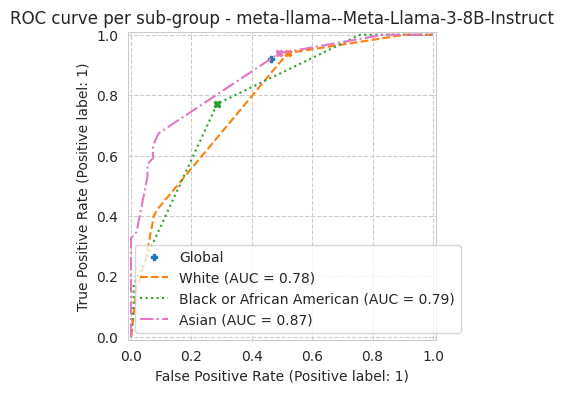

INFO:root:Skipping group American Indian plot as it's too small.
INFO:root:Skipping group Alaska Native plot as it's too small.
INFO:root:Skipping group American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races plot as it's too small.
INFO:root:Skipping group Native Hawaiian and Other Pacific Islander plot as it's too small.
INFO:root:Skipping group Some other race alone (non-White) plot as it's too small.
INFO:root:Skipping group Two or more races plot as it's too small.


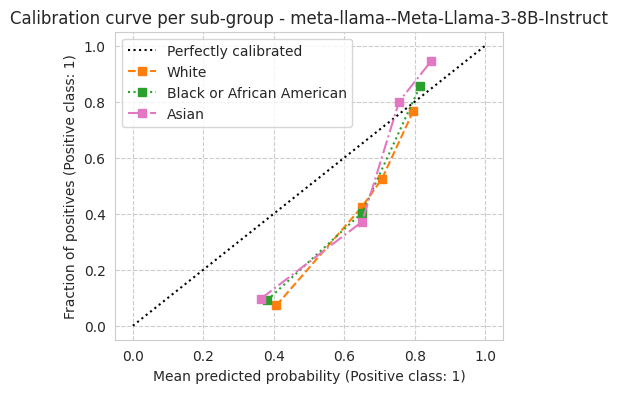

In [18]:
bench.plot_results();

In [19]:
from pprint import pprint
pprint(bench.results, depth=1)

{'accuracy': 0.675075075075075,
 'accuracy_diff': 1.0,
 'accuracy_ratio': 0.0,
 'balanced_accuracy': 0.7277834087010759,
 'balanced_accuracy_diff': 1.0,
 'balanced_accuracy_ratio': 0.0,
 'brier_score_loss': np.float64(0.2292618132401201),
 'config': {...},
 'ece': 0.22473567567567393,
 'ece_quantile': None,
 'equalized_odds_diff': 1.0,
 'equalized_odds_ratio': 0.0,
 'fnr': 0.07933884297520662,
 'fnr_diff': 1.0,
 'fnr_ratio': 0.0,
 'fpr': 0.4650943396226415,
 'fpr_diff': 1.0,
 'fpr_ratio': 0.0,
 'log_loss': 0.6464883164138935,
 'model_name': 'meta-llama--Meta-Llama-3-8B-Instruct',
 'n_negatives': 1060,
 'n_positives': 605,
 'n_samples': 1665,
 'plots': {...},
 'ppr': 0.6306306306306306,
 'ppr_diff': 0.7019230769230769,
 'ppr_ratio': 0.0,
 'precision': 0.5304761904761904,
 'precision_diff': 1.0,
 'precision_ratio': 0.0,
 'predictions_path': '/lustre/fast/fast/groups/sf/folktexts-results/meta-llama--Meta-Llama-3-8B-Instruct/meta-llama--Meta-Llama-3-8B-Instruct_bench-3042776418/ACSIncome_s

---